# Evaluation
## Imports

In [515]:
import ast
import os
os.environ['MODIN_ENGINE'] = 'dask'
import modin.pandas as pd
from collections import Counter

from nltk.corpus import stopwords
stopwords = stopwords.words('german')
import string
from HanTa import HanoverTagger as ht
tagger = ht.HanoverTagger('./morphmodel_ger.pgz')
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing
from scipy.stats import ttest_rel
von  scipy  import  stats

## Load data

In [2]:
chunksize= 10 ** 6
chunks = pd.read_csv('./btw17_rawdata_gender.csv', chunksize=chunksize)
btw17_rawdata_df = pd.concat(chunks)

In [ ]:
btw17_rawdata_df.head(3)

## Preprocessing

In [ ]:
with open('./all_names_to_delete.txt', 'r', encoding='utf-8') as f:
    names = [term[:-1] for term in f.readlines()]
word_pattern = re.compile('\w+')
with open('./all_names_to_delete.txt', 'r', encoding='utf-8') as f:
    names = [term[:-1] for term in f.readlines()]
with open('../dis25-2021/wordlist-german.txt', 'r', encoding='utf-8') as f:
    german_terms = [term[:-1].lower() for term in f.readlines()]

In [ ]:
def delete_names(matchobj)->str:
    word = matchobj.group(0)
    if word in names:
        return ""
    else:
        return word

In [ ]:
def preprocess_keep_duplicates(suggestions:list)->list:
    suggestions = tuple(map(lambda x: x.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))), suggestions))
    suggestions = [word_pattern.sub(delete_names, term.lower()) for term in suggestions]
    suggestions = [suggestion for suggestion in suggestions if len(suggestion.split()) == 1]
    suggestions = tuple(map(lambda x: re.sub('[0-9]*', '', x), suggestions))
    suggestions = [x.lower() for x in suggestions]
    suggestions = [x for x in suggestions if not 'http' in x]
    suggestions = [x for x in suggestions if not x in stopwords]
    suggestions = [tagger.analyze(tagger.analyze(suggestion)[0])[0].lower()
                   for suggestion in suggestions
                   if tagger.analyze(tagger.analyze(suggestion)[0])[1] in ['NN']]
    suggestions = [re.sub('(^..?\s|\s..?\s|\s..?$|^..?$)', '', string) for string in suggestions]
    suggestions = [x.strip() for x in suggestions]
    suggestions = list(filter(None, suggestions))
    suggestions = [term for term in suggestions if term in german_terms]
    return (suggestions)

## Group by gender
*Create one DataFrame for terms suggested for male politicians and one for terms suggested for female politicians*

In [ ]:
female_suggestions = btw17_rawdata_df.groupby('gender').get_group('female')

In [ ]:
male_suggestions = btw17_rawdata_df.groupby('gender').get_group('male')

## Turn DataFrames into flat lists, preprocess the terms of each list and keep the duplicates

\**Preprocessing is performed on slices in a loop and results are saved to file as a workaround for memory errors*

In [ ]:
for i in range(0,len(female_suggestions)+1,int(len(female_suggestions)/10)):
    j = i+int(len(female_suggestions)/10)
    female_suggestions_prep = [term for row in female_suggestions.suggestions[i:j].to_list() for term in ast.literal_eval(row)]
    with open('./female_suggestions_prep.txt','a',encoding='utf-8') as file:
        for item in female_suggestions_prep:
            file.write(item+'\n')

In [ ]:
for i in range(0,len(male_suggestions)+1,int(len(male_suggestions)/10)):
    j = i+int(len(male_suggestions)/10)
    male_suggestions_prep = [term for row in male_suggestions.suggestions.iloc[i:j].to_list() for term in ast.literal_eval(row)]
    with open('./male_suggestions_prep.txt','a',encoding='utf-8') as file:
        for item in male_suggestions_prep:
            file.write(item+'\n')

## Count occurrences of words per cluster and gender

In [2]:
cluster_df = pd.read_csv('./manual_clustering.csv')

In [4]:
cluster_df = cluster_df[1:-1]

In [ ]:
clusters = [ast.literal_eval(cluster) for cluster in cluster_df.cluster_terms.to_list()]

In [ ]:
with open('./female_suggestions_prep.txt', 'r',encoding = 'utf-8') as file:
    female_suggestions = [term[:-1] for term in file.readlines() if term != '']

In [ ]:
female_counts = Counter(female_suggestions)

In [ ]:
for index,cluster in enumerate(clusters):
    count = 0
    for term in cluster:
        count += int(female_counts[term])
    cluster_df.at[index,'female_count'] = count

In [ ]:
cluster_df[['cluster_label','cluster_terms','female_count']].to_csv('./cluster_count_female.csv')

In [ ]:
with open('./male_suggestions_prep.txt', 'r',encoding = 'utf-8') as file:
    content = file.read()
    male_suggestions = content.split('\n')#[term[:-1] for term in file.readlines() if term != '']

In [ ]:
male_counts = Counter(male_suggestions)

In [ ]:
for cluster in clusters:
    count=0
    for term in cluster:
        print(term)
        count+=int(male_counts[term])
    with open('./male_cluster_counts.csv','a') as file:
        file.write(str(count)+'\n')

## Gender Evaluation

In [9]:
btw17_name_gender_df = pd.read_csv('./btw17_name_gender_df.csv')
btw17_name_gender_df.head(5)

,Unnamed: 0,f_name,gender,gender_probability
0,0,Gunnar,male,0.99
1,1,Ates,male,0.90
2,2,bundeskanzlerin,male,1.00
3,3,Michael,male,0.99
4,4,Maurice,male,0.98


In [10]:
politician_df = pd.read_csv('./politiker.csv')
politician_df.head(5)

,Unnamed: 0,Name,Born,Party,Bundesland,Gender,Age
0,0,Wolfgang Stefinger,1985,CSU,Bayern,male,35.0
1,1,Kai Whittaker,1985,CDU,Baden-Württemberg,male,35.0
2,2,Katrin Albsteiger,1983,CSU,Bayern,female,37.0
3,3,Susanna Karawanskij,1980,DIE LINKE,Sachsen,female,40.0
4,4,Florian Oßner,1980,CSU,Bayern,male,40.0


In [11]:
politician_df[['f_name','l_name']] = politician_df['Name'].loc[politician_df['Name'].str.split().str.len() == 2].str.split(expand=True)
politician_df.head(5)

,Unnamed: 0,Name,Born,Party,Bundesland,Gender,Age,f_name,l_name
0,0,Wolfgang Stefinger,1985,CSU,Bayern,male,35.0,Wolfgang,Stefinger
1,1,Kai Whittaker,1985,CDU,Baden-Württemberg,male,35.0,Kai,Whittaker
2,2,Katrin Albsteiger,1983,CSU,Bayern,female,37.0,Katrin,Albsteiger
3,3,Susanna Karawanskij,1980,DIE LINKE,Sachsen,female,40.0,Susanna,Karawanskij
4,4,Florian Oßner,1980,CSU,Bayern,male,40.0,Florian,Oßner


In [12]:
drop_politician_df = politician_df.drop(['Name','Born','Party','Bundesland','Age','l_name'], axis=1)
drop_politician_df.head(5)

,Unnamed: 0,Gender,f_name
0,0,male,Wolfgang
1,1,male,Kai
2,2,female,Katrin
3,3,female,Susanna
4,4,male,Florian


In [13]:
new_btw17_name_gender_df = btw17_name_gender_df.drop(['gender_probability'], axis=1)
new_btw17_name_gender_df.head(5)

,Unnamed: 0,f_name,gender
0,0,Gunnar,male
1,1,Ates,male
2,2,bundeskanzlerin,male
3,3,Michael,male
4,4,Maurice,male


In [14]:
new_politician_df = drop_politician_df.rename(columns={'Gender': 'gender'}, index={'ONE': 'Row_1'})
new_politician_df = new_politician_df[['Unnamed: 0','f_name','gender']]
new_politician_df.head(5)

,Unnamed: 0,f_name,gender
0,0,Wolfgang,male
1,1,Kai,male
2,2,Katrin,female
3,3,Susanna,female
4,4,Florian,male


In [15]:
print(len(new_politician_df))
print(len(new_btw17_name_gender_df))

2510
990


In [16]:
clean_politician_df = new_politician_df.dropna()
clean_new_btw17_name_gender_df = new_btw17_name_gender_df.dropna()

In [17]:
print(len(clean_politician_df))
print(len(clean_new_btw17_name_gender_df))

1188
824


In [18]:
clean_politician_df = clean_politician_df.reset_index(drop=True)
clean_new_btw17_name_gender_df = clean_new_btw17_name_gender_df.reset_index(drop=True)

In [19]:
merged_df = clean_new_btw17_name_gender_df.merge(clean_politician_df, on='f_name').astype(str)
merged_df.columns = ['index','f_name','btw17_gender','index','politician_gender']
print(merged_df)

     index   f_name btw17_gender index politician_gender
0        1     Ates         male   725              male
1        3  Michael         male    34              male
2        3  Michael         male    65              male
3        3  Michael         male    71              male
4        3  Michael         male   144              male
...    ...      ...          ...   ...               ...
1158   984  Bettina       female   919            female
1159   984  Bettina       female   929            female
1160   986   Silvia       female   848            female
1161   987      Max         male   529              male
1162   987      Max         male   718              male

[1163 rows x 5 columns]


In [20]:
gender_x = merged_df['btw17_gender']
gender_y = merged_df['politician_gender']

df_confusion = pd.crosstab(gender_y, gender_x, margins=True)
print(df_confusion)

btw17_gender       female  male   All
politician_gender                    
female                383    25   408
male                   10   745   755
All                   393   770  1163


<Figure size 432x288 with 0 Axes>

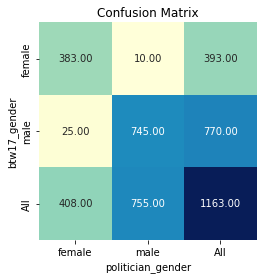

In [22]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = sn.heatmap(df_confusion.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", bbox_inches='tight', dpi=100)
plt.show()

## Gender Cluster Evaluation

In [455]:
cluster_count_female_df = pd.read_csv('./cluster_count_female.csv')
cluster_count_male_df  = pd.read_csv('./male_cluster_counts.csv')

In [456]:
cluster_count_female_df["id"] = cluster_count_female_df.index + 1
cluster_count_female_df.head(10)

,cluster_label,cluster_terms,female_count,id
0,unternehmen_marken,"['bauhaus', 'prosieben', 'sparkasse', 'vorwerk...",153774.0,1
1,sport_hobbies,"['angeln', 'poker', 'liga', 'club', 'league', ...",387765.0,2
2,nachrichten,"['kicker', 'stuttgarter', 'tagesspiegel', 'ver...",164599.0,3
3,militaer_polizei,"['oberstleutnant', 'oberleutnant', 'panzer', '...",46554.0,4
4,technologie_medien,"['information', 'laptop', 'browser', 'javascri...",5164307.0,5
5,kunst_kultur,"['live', 'radio', 'broadcast', 'songs', 'cds',...",862283.0,6
6,bildung,"['schüler', 'gesamtschule', 'realschule', 'obe...",94751.0,7
7,wissenschaft_forschung,"['fraunhofer', 'biologie', 'chemie', 'forschun...",27145.0,8
8,mode_aussehen,"['haar', 'jacke', 'schuh', 'pumps', 'outfit', ...",41138.0,9
9,privatleben,"['ehe', 'oma', 'schwester', 'bruder', 'sohn', ...",2323851.0,10


In [457]:
cluster_count_male_df["id"] = cluster_count_female_df.index + 1
cluster_count_male_df.head(10)

,4759640,id
0,1160934,1
1,1273553,2
2,422864,3
3,256233,4
4,10949863,5
5,2917762,6
6,639067,7
7,216907,8
8,24418,9
9,6582455,10


In [458]:
cluster_count_male_df.columns = ['male_count','id']
cluster_count_male_df.head(10)

,male_count,id
0,1160934,1
1,1273553,2
2,422864,3
3,256233,4
4,10949863,5
5,2917762,6
6,639067,7
7,216907,8
8,24418,9
9,6582455,10


In [459]:
print(cluster_count_male_df.columns)
print(cluster_count_female_df.columns)

Index(['male_count', 'id'], dtype='object')
Index(['cluster_label', 'cluster_terms', 'female_count', 'id'], dtype='object')


In [460]:
cluster_counts_df = cluster_count_female_df.merge(cluster_count_male_df, on='id').astype(str)
cluster_counts_df.columns = ['cluster_label','cluster_terms','female_count','id','male_count']
cluster_counts_df.head(10)

,cluster_label,cluster_terms,female_count,id,male_count
0,unternehmen_marken,"['bauhaus', 'prosieben', 'sparkasse', 'vorwerk...",153774.0,1,1160934
1,sport_hobbies,"['angeln', 'poker', 'liga', 'club', 'league', ...",387765.0,2,1273553
2,nachrichten,"['kicker', 'stuttgarter', 'tagesspiegel', 'ver...",164599.0,3,422864
3,militaer_polizei,"['oberstleutnant', 'oberleutnant', 'panzer', '...",46554.0,4,256233
4,technologie_medien,"['information', 'laptop', 'browser', 'javascri...",5164307.0,5,10949863
5,kunst_kultur,"['live', 'radio', 'broadcast', 'songs', 'cds',...",862283.0,6,2917762
6,bildung,"['schüler', 'gesamtschule', 'realschule', 'obe...",94751.0,7,639067
7,wissenschaft_forschung,"['fraunhofer', 'biologie', 'chemie', 'forschun...",27145.0,8,216907
8,mode_aussehen,"['haar', 'jacke', 'schuh', 'pumps', 'outfit', ...",41138.0,9,24418
9,privatleben,"['ehe', 'oma', 'schwester', 'bruder', 'sohn', ...",2323851.0,10,6582455


In [461]:
female_male_df = cluster_counts_df[['id','female_count', 'male_count']]

female_male_df.head(10)

,id,female_count,male_count
0,1,153774.0,1160934
1,2,387765.0,1273553
2,3,164599.0,422864
3,4,46554.0,256233
4,5,5164307.0,10949863
5,6,862283.0,2917762
6,7,94751.0,639067
7,8,27145.0,216907
8,9,41138.0,24418
9,10,2323851.0,6582455


In [462]:
x = female_male_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df = pd.DataFrame(x_scaled)
normalized_df.columns = ['id','female_norm','male_norm']
normalized_df.head(10)

,id,female_norm,male_norm
0,0.000000,0.029776,0.104718
1,0.058824,0.075085,0.115018
2,0.117647,0.031872,0.037215
3,0.176471,0.009014,0.021975
4,0.235294,1.000000,1.000000
5,0.294118,0.166969,0.265395
6,0.352941,0.018347,0.056989
7,0.411765,0.005256,0.018379
8,0.470588,0.007965,0.000774
9,0.529412,0.449983,0.600563


In [480]:
new_cluster_counts_df = pd.concat([cluster_counts_df, normalized_df], axis=1)
new_cluster_counts_df.head(10)

,cluster_label,cluster_terms,female_count,id,male_count,id,female_norm,male_norm
0,unternehmen_marken,"['bauhaus', 'prosieben', 'sparkasse', 'vorwerk...",153774.0,1,1160934,0.000000,0.029776,0.104718
1,sport_hobbies,"['angeln', 'poker', 'liga', 'club', 'league', ...",387765.0,2,1273553,0.058824,0.075085,0.115018
2,nachrichten,"['kicker', 'stuttgarter', 'tagesspiegel', 'ver...",164599.0,3,422864,0.117647,0.031872,0.037215
3,militaer_polizei,"['oberstleutnant', 'oberleutnant', 'panzer', '...",46554.0,4,256233,0.176471,0.009014,0.021975
4,technologie_medien,"['information', 'laptop', 'browser', 'javascri...",5164307.0,5,10949863,0.235294,1.000000,1.000000
5,kunst_kultur,"['live', 'radio', 'broadcast', 'songs', 'cds',...",862283.0,6,2917762,0.294118,0.166969,0.265395
6,bildung,"['schüler', 'gesamtschule', 'realschule', 'obe...",94751.0,7,639067,0.352941,0.018347,0.056989
7,wissenschaft_forschung,"['fraunhofer', 'biologie', 'chemie', 'forschun...",27145.0,8,216907,0.411765,0.005256,0.018379
8,mode_aussehen,"['haar', 'jacke', 'schuh', 'pumps', 'outfit', ...",41138.0,9,24418,0.470588,0.007965,0.000774
9,privatleben,"['ehe', 'oma', 'schwester', 'bruder', 'sohn', ...",2323851.0,10,6582455,0.529412,0.449983,0.600563


In [482]:
total_female_norm = pd.Series(new_cluster_counts_df['female_norm'], dtype='float').sum()
total_male_norm = pd.Series(new_cluster_counts_df['male_norm'], dtype='float').sum()

new_cluster_counts_df['female_perc'] = new_cluster_counts_df.female_norm.apply(lambda x: float(x) / total_female_norm )
new_cluster_counts_df['male_perc'] = new_cluster_counts_df.male_norm.apply(lambda x: float(x) / total_male_norm )

In [483]:
new_cluster_counts_df = new_cluster_counts_df.drop(['id'], axis=1)

,cluster_label,cluster_terms,female_count,male_count,female_norm,male_norm,female_perc,male_perc
0,unternehmen_marken,"['bauhaus', 'prosieben', 'sparkasse', 'vorwerk...",153774.0,1160934,0.029776,0.104718,0.014066,0.039817
1,sport_hobbies,"['angeln', 'poker', 'liga', 'club', 'league', ...",387765.0,1273553,0.075085,0.115018,0.035470,0.043734
2,nachrichten,"['kicker', 'stuttgarter', 'tagesspiegel', 'ver...",164599.0,422864,0.031872,0.037215,0.015056,0.014150
3,militaer_polizei,"['oberstleutnant', 'oberleutnant', 'panzer', '...",46554.0,256233,0.009014,0.021975,0.004258,0.008356
4,technologie_medien,"['information', 'laptop', 'browser', 'javascri...",5164307.0,10949863,1.000000,1.000000,0.472398,0.380235
5,kunst_kultur,"['live', 'radio', 'broadcast', 'songs', 'cds',...",862283.0,2917762,0.166969,0.265395,0.078876,0.100913
6,bildung,"['schüler', 'gesamtschule', 'realschule', 'obe...",94751.0,639067,0.018347,0.056989,0.008667,0.021669
7,wissenschaft_forschung,"['fraunhofer', 'biologie', 'chemie', 'forschun...",27145.0,216907,0.005256,0.018379,0.002483,0.006988
8,mode_aussehen,"['haar', 'jacke', 'schuh', 'pumps', 'outfit', ...",41138.0,24418,0.007965,0.000774,0.003763,0.000294
9,privatleben,"['ehe', 'oma', 'schwester', 'bruder', 'sohn', ...",2323851.0,6582455,0.449983,0.600563,0.212571,0.228355


In [487]:
new_cluster_counts_df.head(18)

,cluster_label,cluster_terms,female_count,male_count,female_norm,male_norm,female_perc,male_perc
0,unternehmen_marken,"['bauhaus', 'prosieben', 'sparkasse', 'vorwerk...",153774.0,1160934,0.029776,0.104718,0.014066,0.039817
1,sport_hobbies,"['angeln', 'poker', 'liga', 'club', 'league', ...",387765.0,1273553,0.075085,0.115018,0.035470,0.043734
2,nachrichten,"['kicker', 'stuttgarter', 'tagesspiegel', 'ver...",164599.0,422864,0.031872,0.037215,0.015056,0.014150
3,militaer_polizei,"['oberstleutnant', 'oberleutnant', 'panzer', '...",46554.0,256233,0.009014,0.021975,0.004258,0.008356
4,technologie_medien,"['information', 'laptop', 'browser', 'javascri...",5164307.0,10949863,1.000000,1.000000,0.472398,0.380235
5,kunst_kultur,"['live', 'radio', 'broadcast', 'songs', 'cds',...",862283.0,2917762,0.166969,0.265395,0.078876,0.100913
6,bildung,"['schüler', 'gesamtschule', 'realschule', 'obe...",94751.0,639067,0.018347,0.056989,0.008667,0.021669
7,wissenschaft_forschung,"['fraunhofer', 'biologie', 'chemie', 'forschun...",27145.0,216907,0.005256,0.018379,0.002483,0.006988
8,mode_aussehen,"['haar', 'jacke', 'schuh', 'pumps', 'outfit', ...",41138.0,24418,0.007965,0.000774,0.003763,0.000294
9,privatleben,"['ehe', 'oma', 'schwester', 'bruder', 'sohn', ...",2323851.0,6582455,0.449983,0.600563,0.212571,0.228355


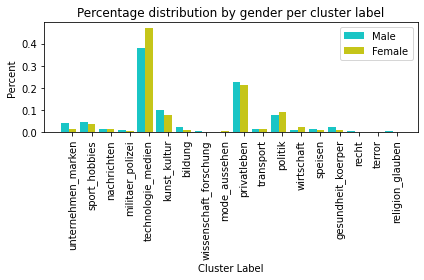

In [543]:
# data to plot
n_cluster = 18
male_perc = new_cluster_counts_df['male_perc']
female_perc = new_cluster_counts_df['female_perc']

# create plot
fig, ax = plt.subplots()
index = np.arange(n_cluster)
bar_width = 0.40
opacity = 0.9

rects1 = plt.bar(index, male_perc, bar_width,
alpha=opacity,
color='c',
label='Male')

rects2 = plt.bar(index + bar_width, female_perc, bar_width,
alpha=opacity,
color='y',
label='Female')

plt.xlabel('Cluster Label')
plt.ylabel('Percent')
plt.title('Percentage distribution by gender per cluster label')
plt.xticks(index + bar_width ,new_cluster_counts_df['cluster_label'], rotation = 90)
plt.legend()

plt.tight_layout()
plt.show()

## Independent T-Test

In [529]:
female_cluster_count = new_cluster_counts_df['female_count'].apply(lambda x: float(x))
male_cluster_count = new_cluster_counts_df['male_count'].apply(lambda x: float(x))

In [542]:
stats.ttest_ind(male_cluster_count,female_cluster_count)




Ttest_indResult(statistic=1.381499152779651, pvalue=0.1761372577988665)